# Fetching SDSS images for source classification

This notebook

- makes an SQL query to the SDSS DR12 database (using its [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx)) to create a catalog, 
- downloads the FITS files,
- use Montage, and
- use Sextractor.

Use the [Docker image](https://github.com/EdwardJKim/deeplearning4astro/tree/master/docker).

In [13]:
%matplotlib inline

import os
import requests
import json
import bz2
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import montage_wrapper as mw
from astropy.io import fits
from astropy import wcs

[SpecObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecObjAll+U)

[PhotoObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)

In [47]:
def sample(n=50000, dr="dr12", timeout=60):
    """
    """
    url = "http://skyserver.sdss.org/{}/en/tools/search/x_sql.aspx".format(dr)
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {} spec.specObjID,
                phot.objID,
                spec.ra,
                spec.dec,
                spec.class,
                spec.z,
                spec.zErr,
                phot.rerun,
                phot.run,
                phot.camcol,
                phot.field,
                phot.dered_u,
                phot.dered_g,
                phot.dered_r,
                phot.dered_i,
                phot.dered_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
                AND spec.ra >= 0
                AND spec.ra < 1
                AND spec.dec >= 0
                AND spec.dec < 1
            --ORDER BY NEWID()
        """.format(n).strip()
    }
    
    try:
        resp = requests.post(url, params=payload, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(e)
        return None

    data = resp.json()[0]['Rows']
    
    df = pd.DataFrame(data)

    return df

In [48]:
s = sample(n=10)

if s is not None:
    s.to_csv("objects.csv")

if os.path.exists("objects.csv"):
    df = pd.read_csv("objects.csv")

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [51]:
def fetch_fits(df):

    bands = [c for c in 'ugriz']
    
    run = df[["rerun", "run", "camcol", "field"]].drop_duplicates()
    
    if not os.path.exists("images/raw"):
        os.makedirs("images/raw")

    for row in run.iterrows():
        r = row[1]
        
        for band in bands:
            url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits.bz2".format(
                r.rerun, r.run, r.camcol, r.field, band)
            filepath = os.path.join("images/raw", filename)
            
            if os.path.exists(filepath.replace(".bz2", "")):
                print("Skipping {}".format(filename))
            else:
                print("Downloading and extracting {}".format(filename))
                
                resp = requests.get(url + filename, stream=True)
            
                with open(filepath.replace(".bz2", ""), "wb") as f:
                    img = bz2.decompress(resp.content)
                    f.write(img)

In [52]:
fetch_fits(df)

Skipping frame-u-004874-4-0421.fits.bz2
Skipping frame-g-004874-4-0421.fits.bz2
Skipping frame-r-004874-4-0421.fits.bz2
Skipping frame-i-004874-4-0421.fits.bz2
Skipping frame-z-004874-4-0421.fits.bz2
Skipping frame-u-004263-4-0116.fits.bz2
Skipping frame-g-004263-4-0116.fits.bz2
Skipping frame-r-004263-4-0116.fits.bz2
Skipping frame-i-004263-4-0116.fits.bz2
Skipping frame-z-004263-4-0116.fits.bz2
Skipping frame-u-002728-5-0413.fits.bz2
Skipping frame-g-002728-5-0413.fits.bz2
Skipping frame-r-002728-5-0413.fits.bz2
Skipping frame-i-002728-5-0413.fits.bz2


In [68]:
ref_images = [f for f in os.listdir("images/raw") if "frame-r-" in f]
# uncomment for production
ref_images = ["frame-r-004874-4-0421.fits"]

[re-projection](http://montage.ipac.caltech.edu/docs/algorithms.html)

In [69]:
if not os.path.exists("images/header"):
    os.makedirs("images/header")

if not os.path.exists("images/registered"):
    os.makedirs("images/registered")

for image in ref_images:
    
    header = os.path.join("images/header", image.replace("frame", "header").replace(".fits", ".hdr"))

    mw.commands.mGetHdr(os.path.join("images/raw", image), header)

    in_images = [os.path.join("images/raw", image.replace("frame-r-", "frame-{}-").format(b)) for b in "ugriz"]
    out_images = [os.path.join("images/registered", image.replace("frame-r-", "registered-{}-").format(b)) for b in "ugriz"]

    mw.reproject(in_images, out_images, header=header, exact_size=True, common=True, silent_cleanup=True)

In [27]:
def convert_catalog_to_exp_pixels(fits_file, catalog, pixel_list):
    """
    """
    
    hdulist = fits.open(fits_file)

    w = wcs.WCS(hdulist[0].header, relax=False)

    df = pd.read_csv(catalog)
    
    with open(pixel_list, "w") as f:
        for row in df.iterrows():
            i, r = row[0], row[1]
            px, py = w.all_world2pix(r.ra, r.dec, 1)
            f.write("{} {} {}\n".format(i, px, py))

In [303]:
image_name = "images/registered/registered-r-004874-4-0421.fits"
convert_catalog_to_exp_pixels(image_name, "objects.csv", "sky.list")

In [304]:
!sex $image_name

> 
----- SExtractor 2.19.5 started on 2015-10-17 at 19:13:24 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing check-image(s)
> Initializing catalog
> Looking for registered-r-004874-4-0421.fits
----- Measuring from: registered-r-004874-4-0421.fits
      "82 N" / no ext. header / 2048x1489 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Settin

In [305]:
df = pd.read_csv("test.cat", comment="#", header=None, delim_whitespace=True)
print(df)

      0     1     2     3     4     5  6
0   163   748   168   753   165   751  4
1  1324   530  1328   536  1326   533  0
2  1864  1186  1869  1191  1867  1189  7


In [343]:
def nanomaggie_to_luptitude(array, band):
    '''
    Converts nanomaggies (flux) to luptitudes (magnitude).

    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    '''
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude

# Take care of NaN values.

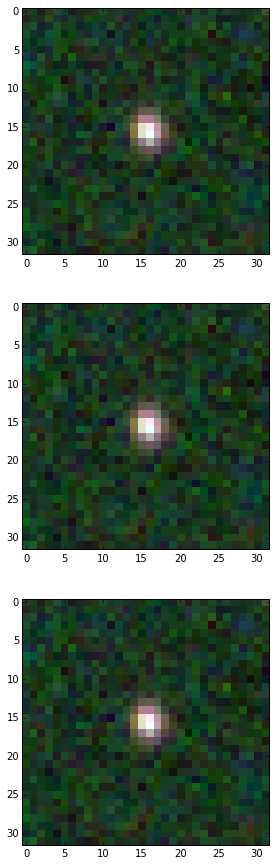

In [345]:
fig, ax = plt.subplots(len(df), figsize=(15, 15))

size = 32

rgb = np.zeros((size, size, 3), dtype=np.uint8)

for row in df.iterrows():
    
    for j, b in enumerate("gri"):
        image_data = fits.getdata(image_name.replace("-r-", "-{}-".format(b)))
    
        i, r = row[0], row[1]
        y0, x0, y1, x1 = r[0:4].values
        
        right = max(0.5 * (size - (x1 - x0)), 1)
        left = max(0.5 * (size - (x1 - x0)), 0)
        up = max(0.5 * (size - (y1 - y0)), 0)
        down = max(0.5 * (size - (y1 - y0)), 1)
    
        cut_out = image_data[x0 - right: x1 + left, y0 - down: y1 + up]
        
        cut_out = nanomaggie_to_luptitude(cut_out, b)

        max_val = cut_out.max()
        min_val = cut_out.min()
    
        cut_out = (max_val - cut_out) / (max_val - min_val) * 255

        rgb[:, :, j] = cut_out
        
    ax[row[0]].imshow(rgb, interpolation='nearest')